**NB:** No arch/structure between objects here. Goals is explore so things added as we go. TODO: refactor into a package 

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from timeit import default_timer as timer 
from datetime import datetime
from tqdm import tqdm

In [3]:
import os, glob, pickle 
import string 

In [3]:
import skimage
from skimage import img_as_float, io, color, exposure, transform, filters

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd


#np.random.seed(9999)

In [6]:
import torch 


In [7]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor  


from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [5]:
class ZSerializableMixin:    ##TODO: at multiple inheritance/decorator MIXIN e.g. @ZRecord        
    data = None
    
    def load(self, fpath):
        with open(fpath, 'rb') as fd:
            self.data = pickle.load(fd)
    
    def save(self, fpath):
        with open(fpath, 'wb') as fd:
            pickle.dump(self.data, fd)


class FundusImageRemapMixin:
    remapped_data = None 
    
    def remap_fundus_img(self):    
        # 1a. resize image 
        self.data = self.resize_image(self.data)
        # 1b. rescale and retype
        self.data = self.image_rescale_retype(self.data)
        # 2. equalize 
        # self.data = self.equalize_image(self.data) << THis makes things 1channel1D
        #print(f"resized, rescaled, equalized: {self.data.shape}", end=", ")
        
        self.remapped_data = []
        # 3. vessels map << run on green Vs gray
        o = self.equalize_image(self.green)
        self.remapped_data.append( self.vessels_map_image(o) )  
        #print(f"vessels mapped", end=", ")
        # 4. color maps: green-details, red-intensity, blue-texture
        
        o = self.equalize_image(self.green)
        self.remapped_data.append( self.green_channel_update(o) )
        
        o = self.equalize_image(self.red)
        self.remapped_data.append( self.red_channel_update(o) )
        
        o = self.equalize_image(self.blue)
        self.remapped_data.append( self.blue_channel_update(o) )
        #print(f"colors mapped", end=", ") 

        # 5. combine and save << combine color maps separately first  for tease 
        outiez = self.combine_channelz(list(self.remapped_data[1:]))
        self.remapped_data.append( outiez )  
        # 5b.
        #self.save_fmap(fout, self.remapped_data )
        #print(f"combined and saved", end=", ")
    
    def image_rescale_retype(self, img):
        outiez = img.copy()
        ## TODO: effect on blue update
#         outiez = outiez/255 ## assuming that's how they come in 
#         outiez = img_as_float(outiez)
        return outiez
    
    def resize_image(self, img):
        return transform.rescale(img, 0.25, anti_aliasing=True, multichannel=True) #im.resize_image((),) #img.copy() 
    
    def equalize_image(self, img):
        ## == TODO: choice at img traits 
        # a. adaptive histogram equalization update
        #outsiez = exposure.equalize_adapthist(img, clip_limit=0.03)
        # b. OR contrast stretching 
        p2, p98 = np.percentile(img, (2,98))
        outsiez = exposure.rescale_intensity(img, in_range=(p2,p98))        
        return outsiez
    
    def vessels_map_image(self, img):
        ## == TODO: tweak for performance 
        ## frangi vesselness << expects grayscale img 
        kwargs = {'sigmas': [1], 'mode': 'reflect', 'black_ridges': 0}
        outsiez = filters.frangi(img) #, **kwargs)        
        return outsiez 
    
    def green_channel_update(self, img):
        return img.copy()  
    
    def red_channel_update(self, img, thresh=0.97):
        outsiez = img.copy()
        red_range = outsiez.max() - outsiez.min()       
        outsiez[( (outsiez-outsiez.min())/red_range) < thresh] = 0   
        return outsiez        
    
    def blue_channel_update(self, img, thresh=1):
        outsiez = img.copy()
        outsiez[outsiez != 1] = 0         
        return outsiez
    
    def combine_channelz(self, cimagez):
        outsiez = np.dstack( cimagez)        
        return outsiez 
    

In [9]:
class ZModality(ZSerializableMixin):
    TYPE_GEN = 0
    TYPE_IMAGE = 1
    TYPE_TEXT = 2 
    
    def __init__(self, label, data=None, mod_type=TYPE_GEN):
        self.mod_type = mod_type
        self.label = label 
        self.data = data
        
    @property
    def size(self):
        return len(self.data) if self.data is not None else 0
    @property
    def stats(self):
        if (isinstance( self.data ,(np.ndarray, np.generic, list, tuple)) ):
            dmean = round(np.mean(self.data),3)
            dmin = round(np.min(self.data),3)
            dmax = round(np.max(self.data),3)
            dsize = self.data.shape if isinstance( self.data ,(np.ndarray, np.generic)) else len(self.data)
        else:
            dmean = 'N/A'
            dmin = min(self.data)
            dmax = max(self.data)
            dsize = len(self.data)
        return f"dtype={type(self.data)}, n={dsize}, min={dmin},  max={dmax},  mean={dmean}"

    def __repr__(self):
        return f"{self.__class__}: n={self.size}, data.dtype={type(self.data)}\n {self.__dict__}"



In [10]:

class ZImage(ZModality):     
    CLR_HSV = 0
    CLR_YUV = 1
    CLR_CIE = 2
    CLR_XYZ = 3 
    COLOR_SPACES = [color.rgb2hsv,
                   color.rgb2yuv,
                   color.rgb2rgbcie,
                   color.rgb2xyz,
                   ]
    
    def __init__(self, label, fpath, mod_type=ZModality.TYPE_IMAGE):
        super().__init__(label, mod_type=mod_type)
        self.fpath = fpath 
        self.data = io.imread( self.fpath ) 
        
    @property        
    def gray(self): 
        return color.rgb2gray( self.data )     
    @property
    def red(self):
        return self.get_channel(0)
    @property
    def green(self):
        return self.get_channel(1)
    @property
    def blue(self):
        return self.get_channel(2)    
    def get_channel(self, cid):
        c = len(self.data.shape)
#         print('get_channel: IN = ', self.data.shape, f" from {c} get {cid}")
        return self.data[:,:,cid] if c >=cid else None     
    
    def get_colorspace(self, cid):
        return ZImage.COLOR_SPACES[cid]( self.data )
       

class ZFundusImage(FundusImageRemapMixin, ZImage):     
    def __init__(self, label, fpath, mod_type=ZModality.TYPE_IMAGE):
        super().__init__(label, fpath, mod_type=mod_type) 


In [12]:
class ZRecord(ZSerializableMixin,list):
    def __init__(self, elements):
        super().__init__(elements)  
        self.data = self 
    ## TODO: self referencing in a list 
    def transform(self, scheme):
        return [m.data*10 for m in self.data]
        
        
class ZDataset(ZSerializableMixin):
    # TODO: A generator connected to some io object or list << can pd do this?? AND/OR batch loads for large files 
    #  pd dataframe to hold objects and do stats 
    #     pandas.DataFrame.transform
    #
    #  scikit @ shuffle, split, << sklearn.model_selection.train_test_split(array, pd, np, tensor??)
    #  scikit pipelines @ ETL transforms 
    #  
    def __init__(self, name='zdataset', durl=None, ):
        self.data = {'name':name, 'durl': durl} 
        self.dframe = pd.DataFrame() 
        self.train_mask = None
        self.test_mask = None
        self.validation_mask = None 


    #### ====== 0. Shuffle and split datasets into train-test-validate, batches, etc ======
    @property 
    def dataset(self): ## TODO: lazy loading from file 
        return self.dframe

    def train_test_validate_split(self, test_perc=0.3, validate_perc=0, shuffle=True):
        self.train_mask, self.test_mask = train_test_split(self.dframe, 
                                                        test_size=test_perc,
                                                        shuffle=shuffle,
                                                        random_state=999)
        print(f"Done splitting {test_perc}% test with shuffle = {shuffle}")


    #### ====== 1. Preprocessing transforms with sklearn pipelines and vectorizers ======


    #### ====== 2. Fetching Data from some resource or a local array ======
    def fetch_data(self, durl, has_header_row=True): ##TODO: refactor @ gen/mem mgt
        self.data['durl'] = durl 
        #self.storage = (r for r in open(durl, 'r')) ##This assumes line per record; would fail with pickled objects, for instance
        storage = []
        with open(durl, 'r') as fd:
            for rec in fd.readlines():
                storage.append( rec.strip().split('\t') )
       #         yield rec 
        self.set_data(storage) 

    ## Iteratively appending rows to a DataFrame can be more computationally intensive than a single concatenate. A better solution is to append those rows to a list and then concatenate the list with the original DataFrame all at once.
    def set_data(self, data, has_header_row=True, headers=None):
        if has_header_row:
            self.dframe = pd.DataFrame.from_records(data[1:], columns=data[0])
        else:
            self.dframe = pd.DataFrame.from_records(data, columns=headers)

    def glob_dir(self, durl, ext):
        self.data['durl'] = durl
        storage = []
        for f in sorted(glob.glob( f"{durl}/*.{ext}") ):
            fname = os.path.splitext( os.path.basename(f) )[0]
            img = io.imread( f )
            ishape = img.shape 
            imin, imax, imean, istd = img.min(), img.max(), img.mean(), img.std()
            storage.append([fname, f, ishape, imin, imax, imean, istd])
        headers = ['fname', 'fpath', 'ishape', 'imin', 'imax', 'imean', 'istd']
        self.set_data(storage, has_header_row=False, headers=headers)

    ## TODO: refactor + generalize 
    ## Pipeline = folder --> subsets --> file --> AnImage --> eq --> colormaps --> vessels --> save --> plot/report     
    def load_stare_fundus_dir(self, 
                              durl="../../data/stare_fundus", ext='ppm',
                              dcodes_txt="disease_codes.txt",
                              data_labelz_txt="all-mg-codes.txt"):

        disease_codez = {} #'7' :[ ['Background Diabetic Retinopathy', 'BDR-NPDR'], ]
        per_file_codez = {} #im0001 :['13 14', 'Choroidal Neovascularization AND Histoplasmosis'] 

        ## 0. disease code infor 
        def load_txt(fname, outds):
            with open(f"{durl}/{fname}", 'r') as fd:
                for f in fd.readlines():
                    rec = f.split("\t")  
                    outds[rec[0]] = [x.strip() for x in rec[1:] if len(x) > 0]
                    #yield rec 


        load_txt(dcodes_txt,disease_codez)
        disease_one_hot = np.eye(len(disease_codez) )
        #print("one-hot shape: ", disease_one_hot.shape)

        #print(disease_codez)
        load_txt(data_labelz_txt,per_file_codez)
        def get_code(fname):
            rec = per_file_codez[fname]
            dcodez = [r for r in rec[0].strip().split(' ') if len(r) >0 and r.isnumeric() ]
            #print(rec)#,"\n",dcodez,"\n")
            dcodez_str = [disease_codez[i] for i in dcodez ] 
            #print(fname, dcodez,"===" ,dcodez_str)

            dcode_one_hot = np.zeros( len(disease_codez) )
            for d in dcodez:
                dcode_one_hot += disease_one_hot[int(d)]

            #print(dcode_one_hot, "---", list(dcode_one_hot))

            return( '++'.join([c for c in dcodez]), 
                    '++'.join([c[1] for c in dcodez_str] ),
                    '++'.join([c[0] for c in dcodez_str] ),
                    '++'.join(rec[-1:]),
                    list(dcode_one_hot) )


        ## 1. glob dir @ image files
        # self.glob_dir(fdir, ext) ## TODO: set fname as an index in dframe 
        self.data['durl'] = durl
        storage = []
        for f in sorted(glob.glob( f"{durl}/*.{ext}") ):
            fname = os.path.splitext( os.path.basename(f) )[0]
            img = io.imread( f )
            ishape = img.shape 
            imin, imax, imean, istd = img.min(), img.max(), img.mean(), img.std()

            dicode, dscode, ddcode, dnotes, dcode_one_hot = get_code(fname) 

            storage.append([fname, f, ishape, imin, imax, imean, istd, 
                            dicode, dscode, ddcode, dnotes]+dcode_one_hot)


        headerz = ['fname', 'fpath', 'ishape', 'imin', 'imax', 'imean', 'istd']        
        fheaderz = ['dcodez_id', 'dcodez_short', 'dcodez_desc', 'dnotes']
        dcode_one_hot_headerz = [r[1] for r in disease_codez.values() ]
        self.set_data(storage, has_header_row=False, headers=headerz+fheaderz+dcode_one_hot_headerz)


    def __repr__(self):
        return f"{self.data}\n{self.dframe.describe()}"




In [32]:
class ZUtilz:
    @staticmethod
    def plot_images_list(img_list, titlez=None, nc=2, cmap=None, tstamp=False,
                         save=None , tdir=".", savedpi=800, withist=False, binz=None):
       
        if withist:   
            n = len(img_list)*2
            nr = n//nc + ( 0 if n%nc == 0 else 1) 
        else:
            n = len(img_list)
            nr = n//nc + ( 0 if n%nc == 0 else 1) 
            
        ## image rows
        for i, img in enumerate(img_list):
            plt.subplot(nr, nc, (i+1) )
            plt.imshow( img, cmap=cmap)
            plt.axis('off')
            if titlez and (i<len(titlez)):
                plt.title( f"{titlez[i]}" ) #min(i, len(titlez)-1)
        
        ## histo rows 
        if withist:      
            for i, img in enumerate(img_list):
                plt.subplot(nr, nc, (i+1)+(n//2) )
                plt.hist(img.flatten()*(1/img.max()), bins=binz)
                plt.tick_params(axis='y', which='both', labelleft=False, labelright=False) #TODO:off
                
        plt.subplots_adjust(wspace=0, hspace=0)
        
        if save:
            d = datetime.now().strftime("%H%M%S")
            fnout = f"{d}_{save}" if tstamp else f"{save}"
            plt.savefig(f"{tdir}/{fnout}.png", dpi=savedpi)
        
        plt.show();

In [31]:
class FuncParsers:    
    fpath_headerz = ['fname', 'fpath']    
    image_fpath_headerz = fpath_headerz + ['ishape', 'imin', 'imax', 'imean', 'istd']
    
    @staticmethod
    def fpath_parser(fpath):        
        fname = os.path.splitext( os.path.basename(fpath) )[0]
        outiez = [fname, fpath] 
        return outiez
    @staticmethod
    def fpath_with_idx_parser(fpath):        
        outiez = FuncParsers.fpath_parser(fpath)
        return outiez[0], outiez[1:]
    @staticmethod
    def fpath_images_parser(fpath):
        outiez = FuncParsers.fpath_parser(fpath)
        img = io.imread(fpath)
        outiez.append( img.shape ) 
        outiez.append( img.min() ) 
        outiez.append( img.max() ) 
        outiez.append( img.mean() ) 
        outiez.append( img.std() )
        return outiez 
    
    @staticmethod
    def file_line_parser(line, sep='\t'):
        outiez = line.strip().split(sep)
        return [x.strip() for x in outiez if len(x) > 0] ##TODO: clean up paranoia 
    @staticmethod
    def file_indexed_line_parser(line, sep='\t'):
        outiez = FuncParsers.file_line_parser(line, sep)
        return outiez[0], outiez[1:]
    
    @staticmethod     
    def stare_fundus_fpath_image_parser(fpath):
        pass
        
class SerializableMixin:
    data = None
    def load(self, fpath):
        with open(fpath, 'rb') as fb:
            self.data = pickle.load(fb) 
    def save(self, fpath):
        with open(fpath, 'wb') as fb:
            pickle.dump( self.data, fb)
            
class FileContentFetcherMixin:
    ## TODO: clean up  + update PdDataStats 
    def file_content(self, pdframe, 
                     fpath_col='fpath', 
                     vcolz=['fname', 'dcodez_short']):
        pdFrameListing = pdframe.loc[:,[fpath_col]+vcolz ]
        for _,fp in pdFrameListing.iterrows():
            #print(fp)#, "\n", dir(fp)) ## TODO: refactor idz
            lbl = fp['fname']
            yield ZRecord( [ ZFundusImage( lbl, fp[fpath_col] ), ## TODO: ZImage refactor generic
                             ZModality( lbl, list(fp[vcolz]) ) ] )
    
     
    
    
            
class PdDataStats(SerializableMixin):
    def __init__(self):
        self.dframe = None 
        self.data = {'name':'pd_from_list_obj'}
        self.train_set = None
        self.test_set = None 
        
        
    ### ==== loading file data @? generator ==== 
    @property
    def size(self):
        return self.dframe.size if self.dframe is not None else 0 
    
    ## TODO: clean up 
    @property
    def file_content(self, fpath_col='fpath', vcolz=['fname', 'dcode']): ## TODO: make useful??,
        #return (f for f in self.select_colz_by_name(vcolz))
        #print("Working Colz: ", [fpath_col,]+vcolz  )
        for _,fp in self.select_colz_by_name( [fpath_col,]+vcolz ).iterrows():
            #print(fp)#, "\n", dir(fp)) ## TODO: refactor idz
            lbl = fp['fname']
            yield ZRecord( [ ZFundusImage( lbl, fp[fpath_col] ), ## TODO: ZImage refactor generic
                             ZModality( lbl, list(fp[vcolz]) ) ] )
    
     
    
    def train_test_validate_split(self, test_perc=0.3, validate_perc=0, shuffle=True):
        self.train_set, self.test_set = train_test_split(self.dframe, 
                                                        test_size=test_perc,
                                                        shuffle=shuffle,
                                                        random_state=999)
        print(f"Done splitting {test_perc}% test with shuffle = {shuffle}")
    
    
    ### ==== loading into pd-frame ====
    def load_list(self, itemz, headerz):
        self.dframe = pd.DataFrame.from_records(itemz, columns=headerz)
    
    def load_file(self, fpath, headerz, parser=FuncParsers.file_line_parser):
        itemz = []
        with open(fpath, 'r') as fd:
            for row in fd.readlines():
                itemz.append( parser(row) )
        self.load_list(itemz, headerz)
        #print( f"Loaded {fpath}: ",len(self.dframe))
        
    
    def load_dir(self, durl, ext,  breaker=None,
                 headerz=FuncParsers.fpath_headerz, 
                 parser=FuncParsers.fpath_parser):
        itemz = []
        for i, fp in enumerate( sorted(glob.glob( f"{durl}/*.{ext}") ) ): 
            itemz.append( parser(fp)  )
            if breaker and (i+1) >= breaker:
                break
        self.load_list(itemz, headerz) 
        
    ## TODO: refactor 
    def load_stare_fundus_dir(self,
                              durl="/mnt/externz/zRepoz/datasets/fundus/stare", ext='ppm', #../../data/stare_fundus
                              dcodes_txt="disease_codes.txt",
                              data_labelz_txt="all-mg-codes.txt"):
        print(f"Loading fundus dir: {durl}")
        disease_codez = {} #'7' :[ ['Background Diabetic Retinopathy', 'BDR-NPDR'], ]
        per_file_codez = {} #im0001 :['13 14', 'Choroidal Neovascularization AND Histoplasmosis'] 
        
        ## 0. disease code infor 
        def load_txt(fname, outds):
            with open(f"{durl}/{fname}", 'r') as fd:
                for f in fd.readlines():
                    k, v = FuncParsers.file_indexed_line_parser(f)  
                    outds[k] = v 
                    #yield rec 
        
                    
        load_txt(dcodes_txt, disease_codez)
        disease_one_hot = np.eye(len(disease_codez) )
        print("one-hot shape: ", disease_one_hot.shape)
        
        #print(disease_codez)
        load_txt(data_labelz_txt, per_file_codez)
        
        def get_code(fname):
            rec = per_file_codez[fname]
            dcodez = [r for r in rec[0].strip().split(' ') if len(r) >0 and r.isnumeric() ]
            #print(rec)#,"\n",dcodez,"\n")
            dcodez_str = [disease_codez[i] for i in dcodez ] 
            #print(fname, dcodez,"===" ,dcodez_str)
            
            dcode_one_hot = np.zeros( len(disease_codez) )
            for d in dcodez:
                dcode_one_hot += disease_one_hot[int(d)]
            
            #print(dcode_one_hot, "---", list(dcode_one_hot))
            
            return( '++'.join([c for c in dcodez]),  #idz
                    '++'.join([c[1] for c in dcodez_str] ), #scodez
                    '++'.join([c[0] for c in dcodez_str] ), #desc
                    '++'.join(rec[-1:]), #notes
                    *list(dcode_one_hot) ) #onehotz
        
        def parser(x):
            outiez = FuncParsers.fpath_images_parser(x)
            outiez += get_code(outiez[0])
            return outiez 
        
        ## 1. glob dir @ image files  
        headerz=FuncParsers.image_fpath_headerz       
        fheaderz = ['dcodez_id', 'dcodez_short', 'dcodez_desc', 'dnotes']
        dcode_one_hot_headerz = [r[1] for r in disease_codez.values() ]
         
        self.load_dir(durl, ext, 
                      headerz=headerz+fheaderz+dcode_one_hot_headerz, 
                      parser=parser)
       
        
        
    ### ==== Stats and Visuals ====
    def select_colz_by_name(self, colz=None):
        return self.dframe.loc[:,colz] if colz is not None else self.dframe
    
    def summarize(self, colz=None, include='all'):
        return self.select_colz_by_name(colz).describe(include=include)
    
    ## TODO: seaborn etc 
    # kind = https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html 
    def visualize(self, colz=None, countz=False, plt_type='bar', **kwargz):
        if countz: ## TODO: refactor, generalize(dframe Vs dseries), Common charts menu 
            return self.dframe[colz].value_counts().plot(kind=plt_type, **kwargz)
        else:
            return self.select_colz_by_name(colz).plot(kind=plt_type, **kwargz) 

In [15]:
class LoadImageFileMixin:
    fpathcol = None
    healthycol = None
    undefcol = None
    
    def file_content(self, dframeX):
        for _,fp in dframeX.loc[:, ['fname',self.fpathcol, self.healthycol, self.undefcol] ].iterrows():
            #print(fp)#, "\n", dir(fp)) ## TODO: refactor idz 
            lbl = fp['fname']
            r = ZFundusImage( lbl, fp[self.fpathcol] ) ##TODO multimodality and fusion 
            r.remap_fundus_img()
            o = np.dstack( [r.remapped_data[0], r.remapped_data[-1]] )             
            #print( r.remapped_data[0].shape, " +++ ", r.remapped_data[-1].shape, " === ", o.shape)
            yield o

            
            
class StareFundusTransformer(LoadImageFileMixin, TransformerMixin, BaseEstimator):
    def __init__(self, fpathcol='fpath', healthycol='Normal', undefcol='UNDEF' ): 
        self.fpathcol = fpathcol
        self.healthycol = healthycol
        self.undefcol = undefcol
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        outiez = []
        for r in self.file_content(X): 
            outiez.append(r)
        return outiez 
    


In [16]:
class Force2DTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #print('len: ', len(X))
        X_ = np.array(X).copy()
        #print("shape: ", X_.shape)
        oX_ = []
        for x in X_:
            w, h, c = x.shape 
            oX_.append( x.flatten() )#x.reshape(w*c, -1) )
        #print("oX.shape: ", oX_[0].shape, " for: ", len(oX_))
        return np.array(oX_)

class YLabelzFundusTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, dscode='dscodez_short', healthycol='Normal', undefcol='UNDEF' ): 
        self.healthycol = healthycol
        self.undefcol = undefcol
        self.dscodez = dscode 
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_['dclass'] = 'UNDEF' 
        X_['dclass_v'] = 0 
        X_.loc[ ( X_[self.healthycol] > 0 ), ['dclass']] = 'Normal' 
        X_.loc[ ( X_[self.healthycol] > 0 ), ['dclass_v']] = 1 
        X_.loc[ (X_[self.healthycol] <= 0) & (X_[self.undefcol] <= 0), ['dclass']] = 'Sick' 
        X_.loc[ (X_[self.healthycol] <= 0) & (X_[self.undefcol] <= 0), ['dclass_v']] = 2
        
#         X_['dclass'] = 'Not Sick' 
#         X_['dclass_v'] = 0  
#         X_.loc[ (X_[self.healthycol] != 1) & (X_[self.undefcol] != 1), ['dclass']] = 'Sick' 
#         X_.loc[ (X_[self.healthycol] != 1) & (X_[self.undefcol] != 1), ['dclass_v']] = 1
        #print(  )
        return X_
    
    
    def inverse_transform(self, X, y=None):
        return X.copy() 
       
class ForShowTargetTransformer(BaseEstimator, TransformerMixin):    
    def fit(self, X, y=None):
        return self
    
    def transform(self, y):
        return y.copy()
    
    
    def inverse_transform(self, y):
        return y.copy()
        

In [17]:
## Stop here if 'run' called as an import/include 
BUILD = False

# recheck

Loading fundus dir: ../../data/stare_fundus
one-hot shape:  (15, 15)


,fname,fpath,ishape,imin,imax,imean,istd,dcodez_id,dcodez_short,dcodez_desc,...,CRVO,Hemi-CRVO,BDR-NPDR,PDR,ASR,HTR,Coats,MA,CNV,UNDEF
count,397,397,397,397.000000,397.000000,397.000000,397.000000,397,397,397,...,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
unique,397,397,1,NaN,NaN,NaN,NaN,48,48,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,im0020,../../data/stare_fundus/im0172.ppm,"(605, 700, 3)",NaN,NaN,NaN,NaN,14,UNDEF,Unknown Diagnosis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,397,NaN,NaN,NaN,NaN,90,90,90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.065491,253.967254,83.071825,73.856816,NaN,NaN,NaN,...,0.062972,0.030227,0.176322,0.057935,0.083123,0.090680,0.035264,0.020151,0.153652,0.400504
std,NaN,NaN,NaN,0.247703,6.358915,15.154158,13.368342,NaN,NaN,NaN,...,0.243220,0.171427,0.381575,0.233914,0.276417,0.287516,0.184680,0.140694,0.361070,0.495739
min,NaN,NaN,NaN,0.000000,179.000000,49.365399,31.962128,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,0.000000,255.000000,72.793943,66.022203,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,0.000000,255.000000,81.432149,76.270379,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,0.000000,255.000000,92.292583,83.227167,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


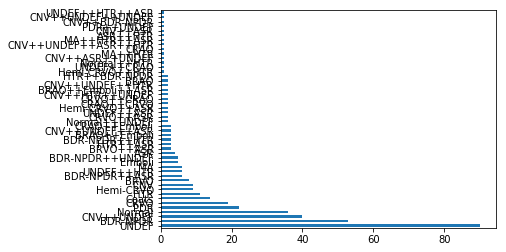

In [18]:
if BUILD:
    idf3 = PdDataStats()
    idf3.load_stare_fundus_dir( )
    idf3.summarize()
    idf3.visualize('dcodez_short', plt_type='barh', countz=True, stacked=False)

In [19]:
if BUILD:
    idf3.train_test_validate_split()
    y_ = YLabelzFundusTransformer()
    y_train = y_.transform(idf3.train_set )['dclass_v'] 
    y_test = y_.transform(idf3.test_set )['dclass_v']  

    etrainX, etestX  = idf3.train_set,idf3.test_set

    train_samples = len(idf3.train_set)

    print(train_samples, y_train.size)


Done splitting 0.3% test with shuffle = True
277 277


In [20]:
if BUILD:
    piper_procs = [
        ('fundusor', StareFundusTransformer()),
        ('force2d', Force2DTransformer()), ## flatten 
        ('rescaler', StandardScaler()),
        #('pca_dim', PCA(n_components=10) ), 
    ]
    logit_m = LogisticRegression(C=50./train_samples, penalty='l1', 
                                   solver='saga', tol=0.0001, 
                                   multi_class='multinomial', 
                                   verbose=2, random_state=9)

In [21]:
if BUILD: 
    piper2 = Pipeline(piper_procs+[('logitor', logit_m), ])

    model = TransformedTargetRegressor(
        regressor = piper2,
        transformer = ForShowTargetTransformer(),
        check_inverse = False )

    model.fit( etrainX, y_train )
    #dir(model)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 151 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished


TransformedTargetRegressor(check_inverse=False, func=None, inverse_func=None,
              regressor=Pipeline(memory=None,
     steps=[('fundusor', StareFundusTransformer(fpathcol='fpath', healthycol='Normal',
            undefcol='UNDEF')), ('force2d', Force2DTransformer()), ('rescaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logitor', LogisticRegression(C=0.18050541516245489, class_weight=None, dual=F...='l1',
          random_state=9, solver='saga', tol=0.0001, verbose=2,
          warm_start=False))]),
              transformer=ForShowTargetTransformer())

In [22]:
if BUILD:
    logitor = model.get_params().get( 'regressor__logitor' , None)

    logitor.__dict__

    if logitor.__dict__.get('coef_', None) is None:
        piper1 = Pipeline(piper_procs)
        etrainX = piper1.fit_transform(idf3.train_set)
        etestX = piper1.transform(idf3.test_set)

        logitor = logit_m

        logitor.fit(etrainX, y_train)

        logitor.__dict__

{'penalty': 'l1',
 'dual': False,
 'tol': 0.0001,
 'C': 0.18050541516245489,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'random_state': 9,
 'solver': 'saga',
 'max_iter': 100,
 'multi_class': 'multinomial',
 'verbose': 2,
 'warm_start': False,
 'n_jobs': None}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 149 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished


LogisticRegression(C=0.18050541516245489, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=9, solver='saga', tol=0.0001, verbose=2,
          warm_start=False)

{'penalty': 'l1',
 'dual': False,
 'tol': 0.0001,
 'C': 0.18050541516245489,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'random_state': 9,
 'solver': 'saga',
 'max_iter': 100,
 'multi_class': 'multinomial',
 'verbose': 2,
 'warm_start': False,
 'n_jobs': None,
 'classes_': array([0, 1, 2]),
 'coef_': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'intercept_': array([ 0.00211102, -0.00555523,  0.00344421]),
 'n_iter_': array([100], dtype=int32)}

In [23]:
if BUILD:
    sparsity = np.mean( logitor.coef_ == 0) * 100 
    score = logitor.score(etestX, y_test)

    print("Sparsity with L1 penalty: %.2f%%" % sparsity)
    print("Test score with L1 penalty: %.4f" % score)


Sparsity with L1 penalty: 89.28%
Test score with L1 penalty: 0.4167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(105700,)
(151, 175, 4)
(151, 175, 4)
(151, 175, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


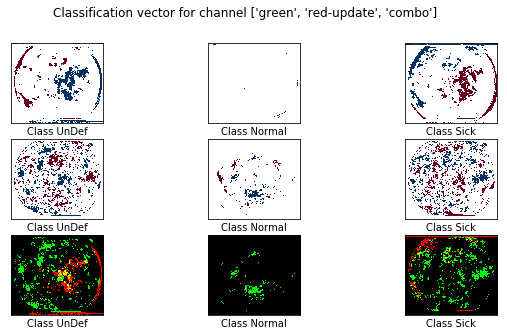

In [28]:
if BUILD:
    CLASS_LABELZ = ['UnDef', 'Normal', 'Sick']

    COEF = logitor.coef_.copy()
    plt.figure(figsize=(10, 5))
    scale = np.abs(COEF).max()
    print( COEF[0].shape )
    for i in range(3):
        cim = COEF[i].reshape((151, 175, -1))
        print(cim.shape )
        for c in [1,2,3]:
            ccm = 1/cim[:,:,c]*1 if c != 3 else cim[:,:,1:]/cim[:,:,:c]
            l1_plot = plt.subplot(3, 3, (i+1)+(3*(c-1)) ) 
            l1_plot.imshow(ccm, interpolation='nearest',
                           cmap=plt.cm.RdBu, vmin=-scale, vmax=scale) #
            l1_plot.set_xticks(())
            l1_plot.set_yticks(())
            l1_plot.set_xlabel( f'Class {CLASS_LABELZ[i]}' )


    plt.suptitle(f"Classification vector for channel {['green','red-update', 'combo']}")

    # run_time = time.time() - t0
    # print('Example run in %.3f s' % run_time)
plt.show();

In [29]:
BUILD = False